In [1]:
# From https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

print(f"torch.cuda.is_available() = {torch.cuda.is_available()}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(f"device = {device}")

torch.cuda.is_available() = True
device = cuda:0


In [2]:
# 1. Load and normalize CIFAR10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../dataset', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../dataset', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


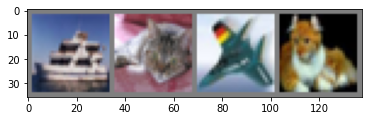

Labels:  ship Labels:   cat Labels: plane Labels:   cat


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('Labels: %5s' % classes[labels[j]] for j in range(batch_size)))

In [4]:
# 2. Define a Convolutional Neural Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().to(device)

In [5]:
# 3. Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
# 4. Train the network
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0


[1,  2000] loss: 2.207
[1,  4000] loss: 1.851
[1,  6000] loss: 1.685
[1,  8000] loss: 1.574
[1, 10000] loss: 1.523
[1, 12000] loss: 1.473
[2,  2000] loss: 1.398
[2,  4000] loss: 1.351
[2,  6000] loss: 1.321
[2,  8000] loss: 1.311
[2, 10000] loss: 1.303
[2, 12000] loss: 1.248


In [7]:
MODEL_PATH="./cifar_net.pth"
torch.save(net.state_dict(), MODEL_PATH)

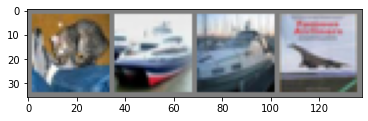

Labels:    cat  ship  ship plane


In [8]:
# 5. Test the network on the test data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Labels: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
# net = Net().to(device)
net.load_state_dict(torch.load(MODEL_PATH))

# Move everything to device. The imshow() above uses numpy and requires cpu device tensors.
net = net.to(device)
images = images.to(device)
labels = labels.to(device)

In [10]:
# Do small prediction
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


In [11]:
# Do prediction on entire test set
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        images = images.to(device)
        labels = labels.to(device)
        
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [12]:
# Hmmm, what are the classes that performed well, and the classes that did not perform well:

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 54.8 %
Accuracy for class car   is: 67.7 %
Accuracy for class bird  is: 41.7 %
Accuracy for class cat   is: 47.5 %
Accuracy for class deer  is: 37.1 %
Accuracy for class dog   is: 41.6 %
Accuracy for class frog  is: 66.3 %
Accuracy for class horse is: 55.0 %
Accuracy for class ship  is: 79.2 %
Accuracy for class truck is: 64.1 %
